This model generates the dose profile from an arbitrary activation profile. It is trained on patient-specific data from a set of 948 pencil beams.

In [1]:
### ONLY FOR GOOGLE COLAB
# Mounting google drive
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir("drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary")
# !pip install livelossplot
###

from train_model import train
from test_model import test
from utils import set_seed, DoseActivityDataset, plot_slices, plot_ddp, DoseActivityDatasetReshaped ###
seed = 42
set_seed(seed)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize#, RandAugment, RandomRotation, GaussianBlur, RandomHorizontalFlip, RandomVerticalFlip
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating the dataset
input_dir = "data/dataset_1/input"
output_dir = "data/dataset_1/output"

# Statistics of the dataset (previously found for the entire Prostate dataset)
mean_input = 0.002942
std_input = 0.036942
max_input = 1.977781
min_input = 0.0

mean_output = 0.00000057475
std_output = 0.00000662656
max_output = 0.00060621166
min_output = 0.0


# Transformations
input_transform = Compose([
    # GaussianBlur(kernel_size=3, sigma=1.0),
    Normalize(mean_input, std_input)
])

output_transform = Compose([
    Normalize(mean_output, std_output)
])

# joint_transform = Compose([
#     RandomRotation(5),
#     RandAugment(magnitude=2),
#     RandomHorizontalFlip(),
#     RandomVerticalFlip()
# ])

# Create dataset applying the transforms
dataset = DoseActivityDatasetReshaped(input_dir=input_dir, output_dir=output_dir,
                              input_transform=input_transform, output_transform=output_transform,
                              num_samples=948, size_reshape=64)

# Split dataset into 70% training, 20% validation, 10% testing
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for training
batch_size = 8  # Largest batch size without running out of memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

from models.TransBTS import TransBTS
# Create the model
model = TransBTS().to(device)

/home/petgfn/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
model_dir = 'models/trained-models/TransBTS-v1.pth'
timing_dir = 'models/training-times/training-time-TransBTS-v1.txt'
n_epochs = 15
trained_model = train(model, train_loader, val_loader, epochs=n_epochs,
                      model_dir=model_dir, timing_dir=timing_dir, mean_output=mean_output, std_output=std_output)

 10%|▉         | 8/83 [00:32<04:53,  3.92s/it]

In [ ]:
# Loading the trained model
model_dir = "models/trained-models/TransBTS-v1.pth"
trained_model = torch.load(model_dir, map_location=torch.device(device))

FileNotFoundError: [Errno 2] No such file or directory: 'models/trained-models/TransBTS-v1.pth'

torch.Size([8, 64, 64, 64])


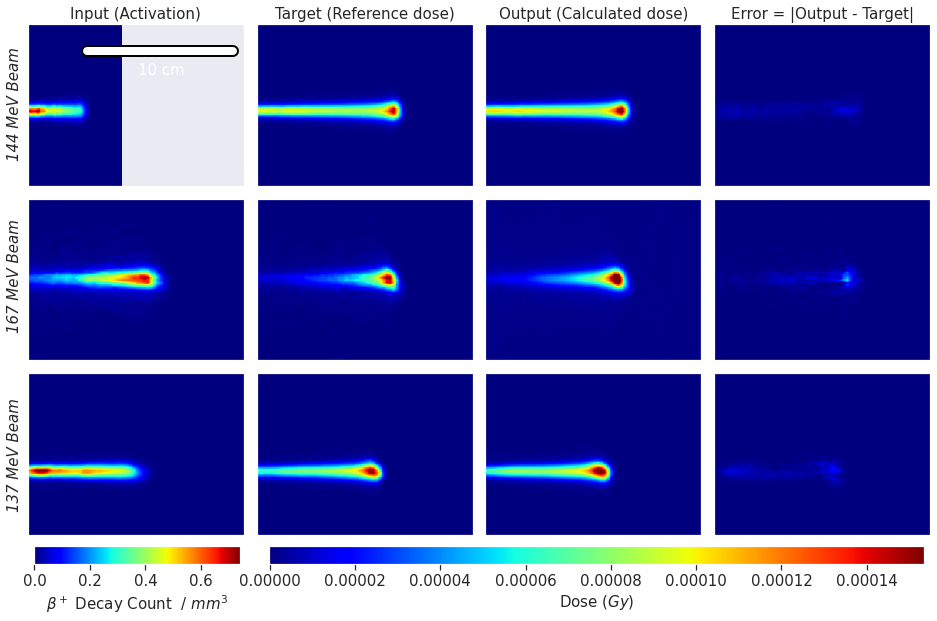

In [ ]:
# Plotting slices of the dose
plot_slices(trained_model, val_loader, device, mean_input=mean_input, std_input=std_input,
            mean_output=mean_output, std_output=std_output,
            save_plot_dir = "images/TransBTS-v1-sample.png", y_slice = 32)

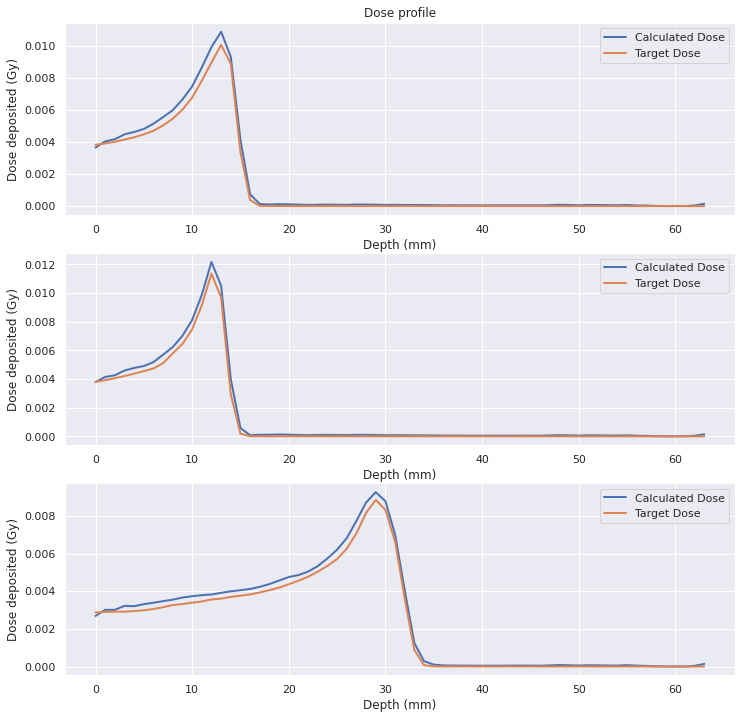

In [ ]:
# Plotting the dose-depth profiles
save_plot_dir = "images/TransBTS-v1-ddp.png"
plot_ddp(trained_model, train_loader, device, mean_output=mean_output,
         std_output=std_output, save_plot_dir = save_plot_dir, y_slice = 60)

In [ ]:
results_dir = 'models/test-results/TransBTS-v1-results.txt'
test(trained_model, test_loader, device, results_dir=results_dir, mean_output=mean_output, std_output=std_output)

100%|██████████| 12/12 [00:14<00:00,  1.18s/it]

Relative Error: 0.027381591498851776 +- 0.2684554159641266
R90: -0.19138239324092865 +- 0.4908999800682068
R90 squared: 0.27758127450942993
R50: -0.16710785031318665 +- 0.18427343666553497
R50 squared: 0.06187768280506134
R10: -0.2145705670118332 +- 0.9923616051673889
R10 squared: 1.0307049751281738
L2 Loss: 0.008418752811849117 +- 0.0009276085183955729
Post BP Loss: 0.05537767708301544 +- 0.015427880920469761
